<a href="https://colab.research.google.com/github/AnzorGozalishvili/active_learning_playground/blob/main/notebooks/regular_sentiment_analysis_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simple Sentiment Analysis Pipeline

Here we train simple 2 layer neural network for sentiment analysis. 

- Model: 2 Fully Connected layer NN (PyTorch)
- Dataset: Sentiment Analysis
- Embedding: spacy en_core_web_lg (mean aggregated embeddings of the text)

Install Requirements from [repository](https://github.com/AnzorGozalishvili/active_learning_playground)

In [ ]:
!wget https://raw.githubusercontent.com/AnzorGozalishvili/active_learning_playground/main/requirements.txt
!pip install -r requirements.txt
!rm requirements.txt
!pip install spacy-sentence-bert==0.1.2

# Imports

In [112]:
# system
import os
import sys

# data and models
import numpy as np
import pandas as pd
import scipy

# utilities
import random
import re
import datetime

# text embeddings
import spacy
import spacy_sentence_bert

# scikit-learn stuff
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score, precision_score, recall_score

# PyTorch stuff
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# visualization
import matplotlib.pyplot as plt
from tqdm import tqdm

# dataset retrieval
from io import BytesIO
from zipfile import ZipFile
from urllib.request import urlopen

# Set Random Seeds
For reproducibility we set several random seeds which are recommended by PyTorch. ([See here](https://pytorch.org/docs/stable/notes/randomness.html))

In [2]:
random.seed(hash("setting random seeds") % 2**32 - 1)
np.random.seed(hash("improves reproducibility") % 2**32 - 1)
torch.manual_seed(hash("PyTorch") % 2**32 - 1)

RANDOM_SEED = 42

# Dataset
Let's download dataset from given [url](https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip), then take a look at samples.

## Retrieve dataset

In [3]:
def get_dataset():
    resp = urlopen("https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip")
    zipfile = ZipFile(BytesIO(resp.read()))
    
    lines = list()
    for line in zipfile.open('SMSSpamCollection').readlines():
        lines.append(line.decode('utf-8'))
    
    data = pd.DataFrame(data=lines)
    new = data[0].str.split("\t", n = 1, expand = True) 
    data["text"]= new[1] 
    data["label"]= new[0] 
    data.drop(columns=[0], inplace = True)
    
    return data

In [4]:
dataset = get_dataset()

## Explore Samples

In [5]:
dataset.head()

,text,label
0,"Go until jurong point, crazy.. Available only ...",ham
1,Ok lar... Joking wif u oni...\n,ham
2,Free entry in 2 a wkly comp to win FA Cup fina...,spam
3,U dun say so early hor... U c already then say...,ham
4,"Nah I don't think he goes to usf, he lives aro...",ham


In [6]:
dataset.shape

(5574, 2)

## Generate Train/Test splits and move forward

We see the imbalance in target variable

In [7]:
dataset.label.value_counts()

ham     4827
spam     747
Name: label, dtype: int64

We have duplicated records

In [8]:
dataset.duplicated().sum()

403

remove these duplicates

In [9]:
dataset.drop_duplicates(inplace=True)

In [10]:
dataset.reset_index(drop=True, inplace=True)

split into train/test splits with 20/80 ratio

In [11]:
train, test = train_test_split(dataset, test_size=0.2, random_state=RANDOM_SEED)

Store these sets into dataset directory

In [17]:
DATASET_NAME = "SMSSpamCollection"
if not os.path.exists('data'):
    os.mkdir('data')
if not os.path.exists(f'data/{DATASET_NAME}'):
    os.mkdir(f'data/{DATASET_NAME}')
    
train.to_csv(f'data/{DATASET_NAME}/train.csv')
test.to_csv(f'data/{DATASET_NAME}/test.csv')

Load again and continue

In [19]:
train = pd.read_csv(f'data/{DATASET_NAME}/train.csv', index_col=0)
test = pd.read_csv(f'data/{DATASET_NAME}/test.csv', index_col=0)

In [20]:
train.shape, test.shape

((4136, 2), (1035, 2))

In [21]:
train.head(2)

,text,label
5132,What about this one then.\n,ham
2067,I will once i get home\n,ham


# Generate Embeddings

We use spacy embeddings to vectorize our samples

In [22]:
class Vectorizer:
    """Generates text embedding using deep learning model"""

    def __init__(self, *args, **kwargs):
        self.model = spacy_sentence_bert.load_model(kwargs.get('model', 'en_paraphrase_distilroberta_base_v1'))
    
    def __call__(self, text):
        if not text:
            text = ""
        
        return self.model(text).vector

In [23]:
vectorizer = Vectorizer()

Downloading:   0%|          | 0.00/391 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.74k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/718 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/329M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.35k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/798k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [24]:
EMBEDDING_DIM = vectorizer('sample text for embedding').shape[0]; 
EMBEDDING_DIM

768

In [47]:
train['vector'] = train.text.apply(vectorizer).apply(lambda x: x.tolist())
test['vector'] = test.text.apply(vectorizer).apply(lambda x: x.tolist())

In [48]:
DATASET_NAME = "SMSSpamCollection"
if not os.path.exists('data'):
    os.mkdir('data')
if not os.path.exists(f'data/{DATASET_NAME}'):
    os.mkdir(f'data/{DATASET_NAME}')
    
train.to_csv(f'data/{DATASET_NAME}/train_vectorized.csv')
test.to_csv(f'data/{DATASET_NAME}/test_vectorized.csv')

In [56]:
train = pd.read_csv(f'data/{DATASET_NAME}/train_vectorized.csv', index_col=0)
test = pd.read_csv(f'data/{DATASET_NAME}/test_vectorized.csv', index_col=0)

train['vector'] = train.vector.apply(eval)
test['vector'] = test.vector.apply(eval)

# PyTorch ML Pipeline

## Model

Example of model is taken from [here](https://github.com/rmunro/pytorch_active_learning/blob/master/active_learning_basics.py)

In [58]:
class MLP(nn.Module):
    """Simple 2 Layer Fully Connected NN (MLP)"""
    
    def __init__(self, num_labels, emb_dim):
        super(MLP, self).__init__()

        # Define model with one hidden layer with 128 neurons
        self.linear1 = nn.Linear(emb_dim, 128)
        self.linear2 = nn.Linear(128, num_labels)

    def forward(self, vector):
        hidden1 = self.linear1(vector).clamp(min=0) # ReLU
        output = self.linear2(hidden1)
        return F.log_softmax(output, dim=1)

In [59]:
MLP(num_labels=2, emb_dim=EMBEDDING_DIM)

MLP(
  (linear1): Linear(in_features=768, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=2, bias=True)
)

In [ ]:

train.sample()

In [124]:
torch.Tensor(train.vector.iloc[:10].values.tolist())

torch.Size([10, 768])

In [164]:
class Trainer:
    """Trains PyTorch model on training data and also evaluated"""

    def __init__(self, *args, **kwargs):
        self.model = kwargs.get('model', MLP(num_labels=2, emb_dim=EMBEDDING_DIM))
        self.loss_function = kwargs.get('loss_function', nn.NLLLoss())
        self.optimizer = kwargs.get('optimizer', optim.SGD(self.model.parameters(), lr=0.01))
        self.label_to_idx = kwargs.get('label_to_idx', {'ham': 0, 'spam': 1})
        self.idx_to_label = {v:k for k,v in self.label_to_idx.items()}
        self.batch_size = kwargs.get('batch_size', 64)
        
        self.losses = []

    def train(self, training_data, test_data, epochs):
        
        for epoch in range(epochs):
            print(f'Epoch: {str(epoch)}')

            shuffled_training_data = training_data.sample(frac=1.0, random_state=RANDOM_SEED + epoch)

            for batch_idx, start_idx in enumerate(range(0, len(shuffled_training_data), self.batch_size)):
                vecs = torch.Tensor(
                    shuffled_training_data.vector.iloc[start_idx:start_idx+self.batch_size].tolist()
                )
                targets = torch.LongTensor(
                    shuffled_training_data.label.iloc[start_idx:start_idx+self.batch_size].apply(lambda x: self.label_to_idx[x]).tolist()
                )

                self.model.zero_grad()
                log_probs = self.model(vecs)

                loss = self.loss_function(log_probs, targets)
                loss.backward()
                self.optimizer.step()
                self.losses.append(loss.item())

                print(f"\tBatch: {batch_idx}\tLoss: {self.losses[-1]}")

        eval_results = self.evaluate(test_data)
        print(f"Evaluation Results: {repr(eval_results)}")

        # save model to path that is alphanumeric and includes number of items and accuracies in filename
        timestamp = re.sub('\.[0-9]*','_',str(datetime.datetime.now())).replace(" ", "_").replace("-", "").replace(":","")
        f1_score = str(eval_results['f1'])            
        model_path = "models/"+timestamp+f1_score+".params"

        if not os.path.exists('models'):
            os.mkdir('models')

        torch.save(self.model.state_dict(), model_path)

        return model_path


    def evaluate(self, dataset):
        targets = []
        preds = []
        probs = []

        with torch.no_grad():
            for idx, row in dataset.iterrows():
                vec = torch.Tensor(row.vector).view(1, -1)
                target = self.label_to_idx[row.label]
        
                logits = self.model(vec)
                prob = np.exp(logits.cpu().data.numpy()[0]).tolist()
                pred = np.argmax(prob)

                probs.append(prob[1])
                preds.append(pred)
                targets.append(target)
        
        results = {
            "f1": round(f1_score(targets, preds, pos_label=1), 3),
            "precision": round(precision_score(targets, preds, pos_label=1), 3),
            "recall": round(recall_score(targets, preds, pos_label=1), 3),
            "roc_auc": round(roc_auc_score(targets, probs, labels=list(self.label_to_idx.keys())), 3),
        }
        
        return results

    def plot_loss(self):
        plt.figure(figsize=(10, 6))
        plt.plot(self.losses)
        plt.show()

In [165]:
LABEL_TO_IDX = {item:idx for idx, item in enumerate(sorted(train.label.unique().tolist()))};
LABEL_TO_IDX

{'ham': 0, 'spam': 1}

In [166]:
mlp = MLP(num_labels=2, emb_dim=EMBEDDING_DIM)

In [167]:
trainer = Trainer(
    **{
        "model": mlp,
        "loss_function": nn.NLLLoss(),
        "optimizer": optim.SGD(mlp.parameters(), lr=0.01),
        "label_to_idx": LABEL_TO_IDX,
        "batch_size": 256,
    }
)

In [168]:
trainer.train(training_data=train, test_data=test, epochs=10)

Epoch: 0
	Batch: 0	Loss: 0.7006976008415222
	Batch: 1	Loss: 0.6923462152481079
	Batch: 2	Loss: 0.6919472217559814
	Batch: 3	Loss: 0.6792134046554565
	Batch: 4	Loss: 0.6740986704826355
	Batch: 5	Loss: 0.6665879487991333
	Batch: 6	Loss: 0.6615784764289856
	Batch: 7	Loss: 0.6523606777191162
	Batch: 8	Loss: 0.6496344208717346
	Batch: 9	Loss: 0.6394569873809814
	Batch: 10	Loss: 0.6366879940032959
	Batch: 11	Loss: 0.6268129348754883
	Batch: 12	Loss: 0.6198194026947021
	Batch: 13	Loss: 0.6122130751609802
	Batch: 14	Loss: 0.6036674976348877
	Batch: 15	Loss: 0.6109205484390259
	Batch: 16	Loss: 0.6451691389083862
Epoch: 1
	Batch: 0	Loss: 0.5963299870491028
	Batch: 1	Loss: 0.5895066261291504
	Batch: 2	Loss: 0.5847741365432739
	Batch: 3	Loss: 0.5800781846046448
	Batch: 4	Loss: 0.5626293420791626
	Batch: 5	Loss: 0.5618782639503479
	Batch: 6	Loss: 0.5759237408638
	Batch: 7	Loss: 0.5480124950408936
	Batch: 8	Loss: 0.5573577284812927
	Batch: 9	Loss: 0.5636530518531799
	Batch: 10	Loss: 0.55343556404113

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


'models/20211123_213901_0.0.params'

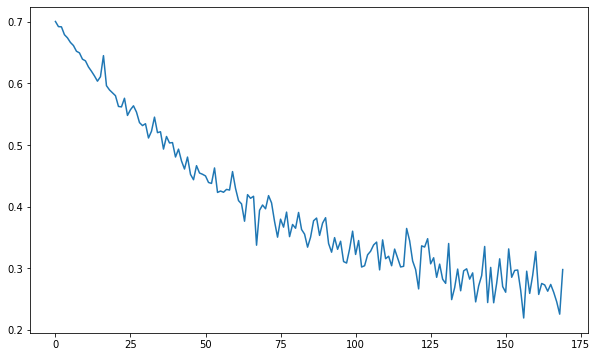

In [169]:
trainer.plot_loss()